In [1]:
# Building a convex potential flow
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims):
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims
        self.alpha = 1.0

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()


        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx==0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None

        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)
            if i==0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights and output layer.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad():
            for i in range(1, len(self.Wz_layers)):
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
            
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.copy_(torch.abs(self.output_layer.weight))



In [ ]:
class DeepConvexFlow(torch.nn.Module):
    """
    Deep convex potential flow parameterized by an input-convex neural network
    """

    def __init__(self, icnn, dim, unbiased=False, no_bruteforce=True, m1=10, m2=None, rtol=0.0, atol=1e-3,
                 bias_w1=0.0, trainable_w0=True):
        super(DeepConvexFlow, self).__init__()
        if m2 is None:
            m2 = dim
        self.icnn = icnn
        self.no_bruteforce = no_bruteforce
        self.rtol = rtol
        self.atol = atol

        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)
        self.bias_w1 = bias_w1

        self.m1, self.m2 = m1, m2
        
    def get_potential(self, x, context=None):
        n = x.size(0)
        if context is None:
            icnn = self.icnn(x)
        else:
            icnn = self.icnn(x, context)
        return F.softplus(self.w1) * icnn + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2

    def reverse(self, y, max_iter=1000000, lr=1.0, tol=1e-12, x=None, context=None, **kwargs):
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Solves x such that f(x) - y = 0
            # <=> Solves x such that argmin_x F(x) - <x,y>
            F = self.get_potential(x, context)
            loss = torch.sum(F) - torch.sum(x * y)
            x.grad = torch.autograd.grad(loss, x)[0].detach()
            return loss

        optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, tolerance_grad=tol,
                                      tolerance_change=tol)

        optimizer.step(closure)

        error_new = (self.forward_transform(x, context=context)[0] - y).abs().max().item()
        # if error_new > math.sqrt(tol):
        #     print('inversion error', error_new, flush=True)
        torch.cuda.empty_cache()
        gc.collect()

        return x

    def forward(self, x, context=None):
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x, context)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f

    def forward_transform(self, x, logdet=0, context=None, extra=None):

        return self.forward_transform_bruteforce(x, logdet, context=context)

    def forward_transform_bruteforce(self, x, logdet=0, context=None):
        warnings.warn('brute force')
        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x.requires_grad_(True)
            F = self.get_potential(x, context)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

            # TODO: compute Hessian in block mode instead of row-by-row.
            f = f.reshape(bsz, -1)
            H = []
            for i in range(f.shape[1]):
                retain_graph = self.training or (i < (f.shape[1] - 1))
                H.append(
                    torch.autograd.grad(f[:, i].sum(), x, create_graph=self.training, retain_graph=retain_graph)[0])

            # H is (bsz, dim, dim)
            H = torch.stack(H, dim=1)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + torch.slogdet(H).logabsdet

    def extra_repr(self):
        return f"ConjGrad(rtol={self.rtol}, atol={self.atol})"


/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(


Text(0.5, 1.0, 'Transformed Base Distribution Samples')

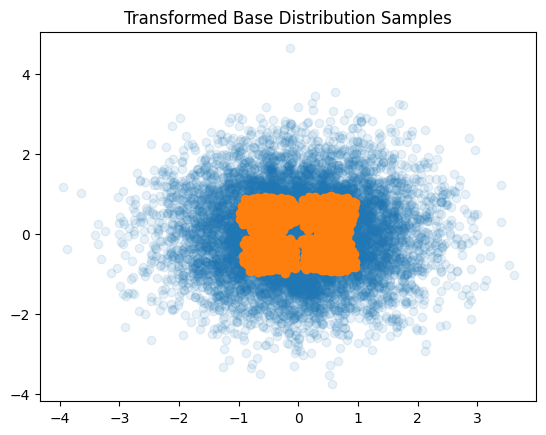

In [4]:
base = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
def T(xy):
    x = xy[:,0]
    y = xy[:,1]
    return np.stack([np.cbrt(1/4 * x), np.cbrt(1/4 * y)], axis=1)

X = T(base.sample_n(10000).cpu().numpy())

base_samples = base.sample_n(10000).cpu().numpy()
plt.scatter(base_samples[:,0], base_samples[:,1], alpha=0.1, label='Base Samples')
plt.scatter(X[:,0], X[:,1], alpha=1, label='Transformed Samples')
plt.title('Transformed Base Distribution Samples')

In [6]:
from torch.utils.data import DataLoader, TensorDataset

model = DeepConvexFlow(
    icnn=ICNN(n_dim=2, hidden_dims=[8, 16, 32, 16, 8]),
    dim=2).to(device)


def train(X, model, epochs=200, lr=5e-2, dim=2):
    EPOCHS = epochs
    LR=lr
    base = torch.distributions.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)


            y, logdet = model.forward_transform(x_batch, logdet=0.0)
            logp0 = base.log_prob(y)
            logpx = logp0 + logdet

            loss = -logpx.mean()  # NLL = reverse KL

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.icnn.enforce_constraints()  # Enforce non-negativity constraints


            total_loss += loss.item() * x_batch.size(0)
        
        scheduler.step()

        
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}")

train(X, model, epochs=200, lr=5e-2)

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/tmp/ipykernel_1382/1469587878.py:67: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/200, NLL = 1.6894
Epoch 10/200, NLL = 1.6898
Epoch 15/200, NLL = 1.5757
Epoch 20/200, NLL = 1.3008
Epoch 25/200, NLL = 0.7088
Epoch 30/200, NLL = 0.6282
Epoch 35/200, NLL = 0.6301
Epoch 40/200, NLL = 0.6195
Epoch 45/200, NLL = 0.6146
Epoch 50/200, NLL = 0.6055
Epoch 55/200, NLL = 0.6034
Epoch 60/200, NLL = 0.6046
Epoch 65/200, NLL = 0.6050
Epoch 70/200, NLL = 0.6097
Epoch 75/200, NLL = 0.6021
Epoch 80/200, NLL = 0.6009
Epoch 85/200, NLL = 0.6009
Epoch 90/200, NLL = 0.6006
Epoch 95/200, NLL = 0.6060
Epoch 100/200, NLL = 0.5998
Epoch 105/200, NLL = 0.5986
Epoch 110/200, NLL = 0.5996
Epoch 115/200, NLL = 0.5986


KeyboardInterrupt: 

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
/tmp/ipykernel_1382/1469587878.py:67: UserWarning: brute force
  warnings.warn('brute force')


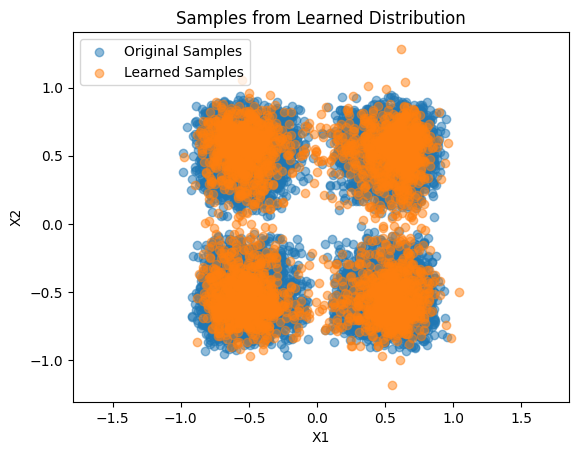

In [7]:
flow_samples = model.reverse(base.sample_n(3000).to(device), max_iter=1000, lr=1.0, tol=1e-12)
flow_samples = flow_samples.detach().cpu().numpy()

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='Learned Samples', alpha=0.5)

plt.title('Samples from Learned Distribution')
plt.xlabel('X1')
plt.ylabel('X2')

plt.legend()
plt.axis('equal')
plt.show()

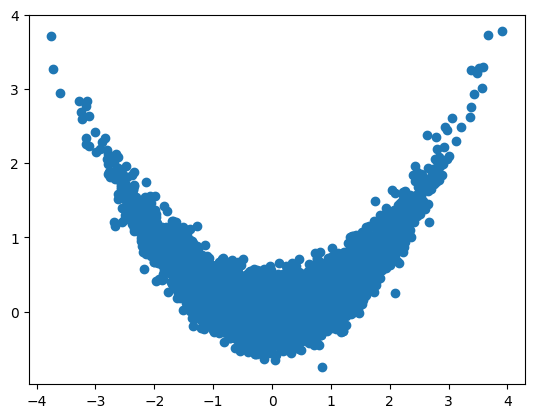

In [36]:
def sample_banana(n_samples=5000, sigma=1.0, noise=0.2):
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

# Sample data
X = sample_banana(10000)
plt.scatter(X[:,0], X[:,1])

In [39]:
from torch.utils.data import DataLoader, TensorDataset

model = DeepConvexFlow(
    icnn=ICNN(n_dim=2, hidden_dims=[8, 16, 32, 16, 8]),
    dim=2).to(device)

train(X, model, epochs=200, lr=5e-2)

/tmp/ipykernel_6135/4037186518.py:71: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/200, NLL = 1.5664
Epoch 10/200, NLL = 1.4097
Epoch 15/200, NLL = 1.2678
Epoch 20/200, NLL = 1.2481
Epoch 25/200, NLL = 1.2572
Epoch 30/200, NLL = 1.2386
Epoch 35/200, NLL = 1.2359
Epoch 40/200, NLL = 1.2465
Epoch 45/200, NLL = 1.2365
Epoch 50/200, NLL = 1.2338
Epoch 55/200, NLL = 1.2264
Epoch 60/200, NLL = 1.2323
Epoch 65/200, NLL = 1.2249
Epoch 70/200, NLL = 1.2270
Epoch 75/200, NLL = 1.2241
Epoch 80/200, NLL = 1.2341
Epoch 85/200, NLL = 1.2302
Epoch 90/200, NLL = 1.2289
Epoch 95/200, NLL = 1.2286
Epoch 100/200, NLL = 1.2258
Epoch 105/200, NLL = 1.2217
Epoch 110/200, NLL = 1.2244
Epoch 115/200, NLL = 1.2253
Epoch 120/200, NLL = 1.2223
Epoch 125/200, NLL = 1.2219
Epoch 130/200, NLL = 1.2238
Epoch 135/200, NLL = 1.2213
Epoch 140/200, NLL = 1.2208
Epoch 145/200, NLL = 1.2245
Epoch 150/200, NLL = 1.2222
Epoch 155/200, NLL = 1.2208
Epoch 160/200, NLL = 1.2198
Epoch 165/200, NLL = 1.2208
Epoch 170/200, NLL = 1.2207
Epoch 175/200, NLL = 1.2206
Epoch 180/200, NLL = 1.2209
Epoch 185/20

/home/mohamed/miniconda3/lib/python3.12/site-packages/torch/distributions/distribution.py:179: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn(
/tmp/ipykernel_6135/4037186518.py:71: UserWarning: brute force
  warnings.warn('brute force')


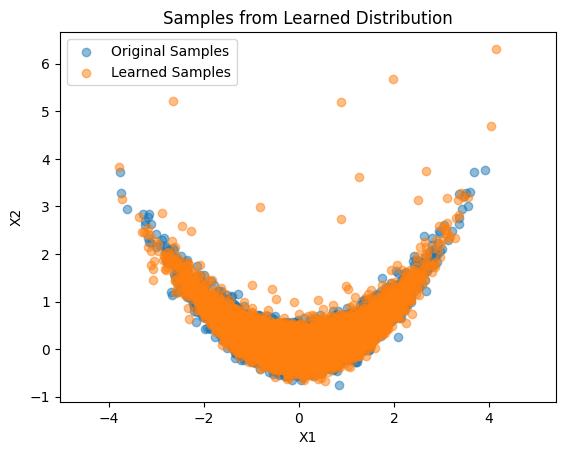

In [40]:
flow_samples = model.reverse(base.sample_n(10000).to(device), max_iter=1000, lr=1.0, tol=1e-12)
flow_samples = flow_samples.detach().cpu().numpy()


plt.scatter(X[:,0], X[:,1], alpha=0.5, label='Original Samples')
plt.scatter(flow_samples[:,0], flow_samples[:,1], label='Learned Samples', alpha=0.5)

plt.title('Samples from Learned Distribution')
plt.xlabel('X1')
plt.ylabel('X2')

plt.legend()
plt.axis('equal')
plt.show()

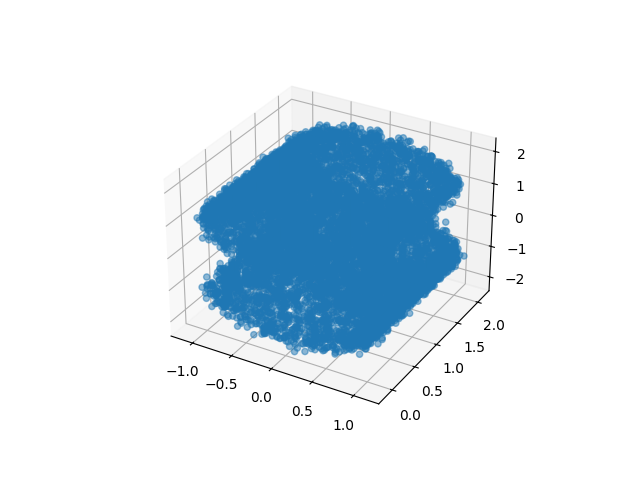

In [42]:
%matplotlib widget
from sklearn.datasets import make_s_curve

X, _ = make_s_curve(n_samples=10000, noise=0.05, random_state=42)
# graph 3d s curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5)


In [49]:
model = DeepConvexFlow(
    icnn=ICNN(n_dim=3, hidden_dims=[8, 32, 64, 32, 8]),
    dim=3).to(device)

train(X, model, epochs=300, lr=5e-2, dim=3)

/tmp/ipykernel_6135/4037186518.py:71: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/300, NLL = 3.7509
Epoch 10/300, NLL = 3.5075
Epoch 15/300, NLL = 3.3473
Epoch 20/300, NLL = 3.2924
Epoch 25/300, NLL = 3.0100
Epoch 30/300, NLL = 2.5412
Epoch 35/300, NLL = 2.3568
Epoch 40/300, NLL = 2.0672
Epoch 45/300, NLL = 1.9054
Epoch 50/300, NLL = 1.8620
Epoch 55/300, NLL = 1.8071
Epoch 60/300, NLL = 1.8034
Epoch 65/300, NLL = 1.7860
Epoch 70/300, NLL = 1.7868
Epoch 75/300, NLL = 1.7745
Epoch 80/300, NLL = 1.7628
Epoch 85/300, NLL = 1.7652
Epoch 90/300, NLL = 1.7606
Epoch 95/300, NLL = 1.7498
Epoch 100/300, NLL = 1.7371
Epoch 105/300, NLL = 1.7231
Epoch 110/300, NLL = 1.7265
Epoch 115/300, NLL = 1.7221
Epoch 120/300, NLL = 1.7190
Epoch 125/300, NLL = 1.7205
Epoch 130/300, NLL = 1.7103
Epoch 135/300, NLL = 1.7185
Epoch 140/300, NLL = 1.7136
Epoch 145/300, NLL = 1.7076
Epoch 150/300, NLL = 1.7037
Epoch 155/300, NLL = 1.6909
Epoch 160/300, NLL = 1.6871
Epoch 165/300, NLL = 1.6860
Epoch 170/300, NLL = 1.6850
Epoch 175/300, NLL = 1.6791
Epoch 180/300, NLL = 1.6781
Epoch 185/30

/tmp/ipykernel_6135/4037186518.py:71: UserWarning: brute force
  warnings.warn('brute force')


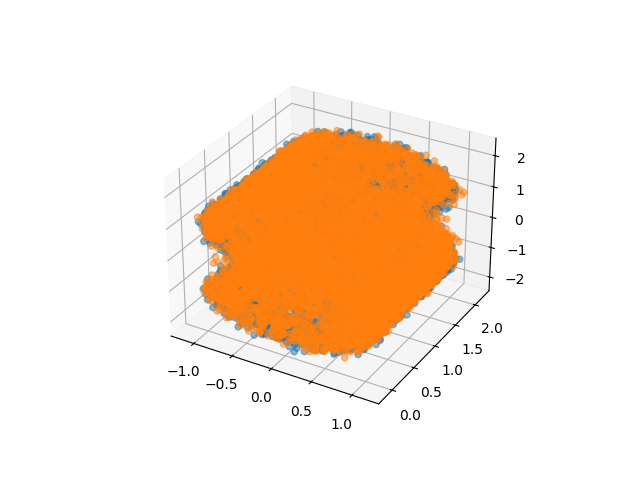

In [50]:
%matplotlib widget
base = torch.distributions.MultivariateNormal(torch.zeros(3, device=device), torch.eye(3, device=device))
flow_samples = model.reverse(base.sample_n(10000).to(device), max_iter=1000, lr=1.0, tol=1e-12)
flow_samples = flow_samples.detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5)

ax.scatter(flow_samples[:, 0], flow_samples[:, 1], flow_samples[:, 2], alpha=0.5)